In [7]:

from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

import sys
import warnings

warnings.filterwarnings("ignore")

/opt/conda/envs/llavanext/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/llavanext/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
import json

dataset_dir = '/mnt/disks/data/webqa/WebQA_train_val.json'
with open(dataset_dir, 'r') as f:
    data = json.load(f)

In [ ]:
val_data = {}
for id,dict in data.items():
    if dict['Qcate'] == 'text':
        continue
    elif not dict['split'] == 'val':
        continue
    elif not len(dict['img_posFacts']) > 0:
        continue
    val_data[id] = dict

print(len(val_data))


In [8]:
from io import BytesIO
import base64
from PIL import Image

lineidx_dir = '/mnt/disks/data/webqa/imgs.lineidx'
images_dir = '/mnt/disks/data/webqa/imgs.tsv'

with open(lineidx_dir, "r") as fp_lineidx:
    lineidx = [int(i.strip()) for i in fp_lineidx.readlines()]

def read_image(image_id):
    with open(images_dir, "r") as fp:
        fp.seek(lineidx[int(image_id)%10000000])
        imgid, img_base64 = fp.readline().strip().split('\t')
    assert int(image_id) == int(imgid), f'{image_id} {imgid}'
    im = Image.open(BytesIO(base64.b64decode(img_base64)))
    if im.mode != 'RGB':
        im = im.convert('RGB')  # Convert to RGB if not already
    return im


In [26]:
def get_multihop_prompt(ques, titles, captions):
    question = f"{DEFAULT_IMAGE_TOKEN} This is the first image.\nTitle: {titles[0]}\nCaption: {captions[0]}\n\nNow, let's look at another image: {DEFAULT_IMAGE_TOKEN} Title: {titles[1]}\nCaption: {captions[1]}\nRespond with the correct answer to the following question in a complete sentence. Question: {ques}"
    return question

def get_si_prompt(ques, titles, captions):
    question = f"{DEFAULT_IMAGE_TOKEN} You have to answer a question about this image\nTitle: {titles[0]}\nCaption: {captions[0]}\nRespond with the correct answer to the following question in a complete sentence. Question: {ques}"
    return question

def get_answer(data, model, image_processor, tokenizer, max_len, device):
    ques = data['Q']
    images = []
    titles = []
    captions = []
    for img in data['img_posFacts']:
        images.append(read_image(img['image_id']))
        titles.append(img['title'])
        captions.append(img['caption'])
    if len(images) == 2:
        prompt = get_multihop_prompt(ques, titles, captions)
    else:
        prompt = get_si_prompt(ques, titles, captions)
    image_tensors = process_images(images, image_processor, model.config)
    image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
    
    conv_template = "qwen_1_5"
    conv = copy.deepcopy(conv_templates[conv_template])
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    prompt_question = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    image_sizes = [image.size for image in images]
    print(prompt_question)
    # Generate response
    cont = model.generate(
        input_ids,
        images=image_tensors,
        image_sizes=image_sizes,
        do_sample=False,
        temperature=0,
        max_new_tokens=4096,
    )
    text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
    return text_outputs[0]

In [ ]:
count = 0
for id, d in val_data.items():
    if len(d['img_posFacts']) > 1:
        count += 1
        print(d)
        if count > 2:
            break

In [9]:
## Load model
# pretrained = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
pretrained = "lmms-lab/llava-onevision-qwen2-7b-ov"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
llava_model_args = {
        "multimodal": True,
    }
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config
tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, load_8bit=True, **llava_model_args)

model.eval()

Loaded LLaVA model: lmms-lab/llava-onevision-qwen2-7b-ov


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Overwriting config with {'image_aspect_ratio': 'pad'}
Loading vision tower: google/siglip-so400m-patch14-384


Loading checkpoint shards: 100%|██████████| 4/4 [01:04<00:00, 16.18s/it]


Model Class: LlavaQwenForCausalLM


LlavaQwenForCausalLM(
  (model): LlavaQwenModel(
    (embed_tokens): Embedding(151647, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2FlashAttention2(
          (q_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear8bitLt(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
 

In [27]:
from IPython.display import display
dataset_dir = '/mnt/disks/data/webqa/WebQA_test.json'
lineidx_dir = '/mnt/disks/data/webqa/imgs.lineidx'
images_dir = '/mnt/disks/data/webqa/imgs.tsv'
retrieved_dir = '/mnt/disks/data/webqa/WebQA_retrieved_test.json'

# Map test set images to IDs
img_url_to_id = {}
with open(dataset_dir, 'r') as f:
    test_data = json.load(f)

with open(retrieved_dir, 'r') as f:
    retrieved_data = json.load(f)

for qid,d in test_data.items():
    for img in d['img_Facts']:
        img_url_to_id[img['imgUrl']] = img['image_id']

with open(lineidx_dir, "r") as fp_lineidx:
    lineidx = [int(i.strip()) for i in fp_lineidx.readlines()]

# Image context (1,2) + Text context (1,2) + Question
# For cases where Img context = 0; use multimodal = False config and re-run the generation
def get_multihop_image_prompt(titles):
    question = f"{DEFAULT_IMAGE_TOKEN} This is the first image.\nTitle: {titles[0]}\n\nNow, let's look at another image: {DEFAULT_IMAGE_TOKEN} Title: {titles[1]}\n"
    return question

def get_si_prompt(titles):
    question = f"{DEFAULT_IMAGE_TOKEN} Consider this image\nTitle: {titles[0]}\n"
    return question

def get_multihop_text_prompt(texts):
    question = f"Fact 1: {texts[0]}\n\nFact 2: {texts[1]}\n"
    return question

def get_single_text_prompt(texts):
    question = f"Fact: {texts[0]}\n"
    return question

def get_ques_prompt(q):
    question = f"Given all of the relevant context before, respond with the correct answer to the following question in a complete sentence. Question: {q}"
    return question


def get_test_answer(data, model, image_processor, tokenizer, max_len, device):
    ques = data['Q']
    images = []
    titles = []
    texts = []
    for img in data['img_Facts']:
        image_id = img_url_to_id[img['imgUrl']]
        images.append(read_image(image_id))
        titles.append(img['title'])
    for txt in data['txt_Facts']:
        texts.append(txt['fact'])
    print(data)
    print(images[0].mode)
    display(images[0])
    print(images[1].mode)
    display(images[1])
    # skip if no images
    if len(images) == 2:
        promptImg = get_multihop_image_prompt(titles)
    elif len(images) == 1:
        promptImg = get_si_prompt(titles)
    else:
        return ""

    promptTxt = ""
    if len(texts) == 2:
        promptTxt = get_multihop_text_prompt(texts)
    elif len(texts) == 1:
        promptTxt = get_single_text_prompt(texts)
    
    prompt = promptImg + promptTxt + get_ques_prompt(ques)
    image_tensors = process_images(images, image_processor, model.config)
    image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
    
    conv_template = "qwen_1_5"
    conv = copy.deepcopy(conv_templates[conv_template])
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    prompt_question = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    image_sizes = [image.size for image in images]
    # Generate response
    cont = model.generate(
        input_ids,
        images=image_tensors,
        image_sizes=image_sizes,
        do_sample=False,
        temperature=0,
        max_new_tokens=4096,
    )
    text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
    return text_outputs[0]


{'Q': '"Do the Old Fort in New Delhi and the Great Mosque in New Delhi both have rows of 5 archways of the same size?"', 'img_Facts': [{'imgUrl': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Old_Fort_New_Delhi.JPG/800px-Old_Fort_New_Delhi.JPG', 'title': 'Old Fort New Delhi'}, {'imgUrl': 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Jama_Mosque_Old_Delhi%2C_full_view.jpg/800px-Jama_Mosque_Old_Delhi%2C_full_view.jpg', 'title': 'Jama Mosque Old Delhi, full view'}], 'split': 'test', 'txt_Facts': [{'fact': "\u2009'Old Fort') is one of the oldest forts in Delhi, India. It is located near the expansive Pragati Maidan exhibition ground and is separated from the Dhyanchand Stadium by the Mathura Road, Delhi.", 'snippet_id': 'd5bc5cec0dba11ecb1e81171463288e9_7'}, {'fact': "In the Old City, the Mughals and the Turkic rulers constructed several architecturally significant buildings, such as the Jama Masjid—India's largest mosque built in 1656 and the Red Fort. Three Worl

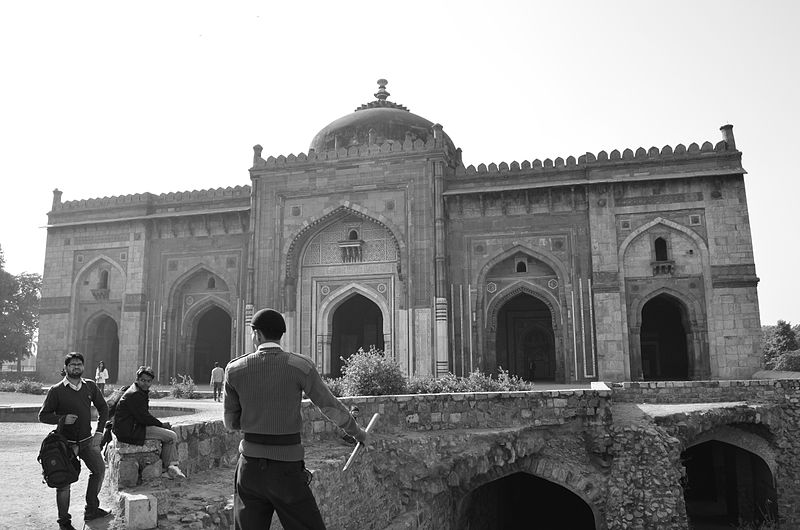

RGB


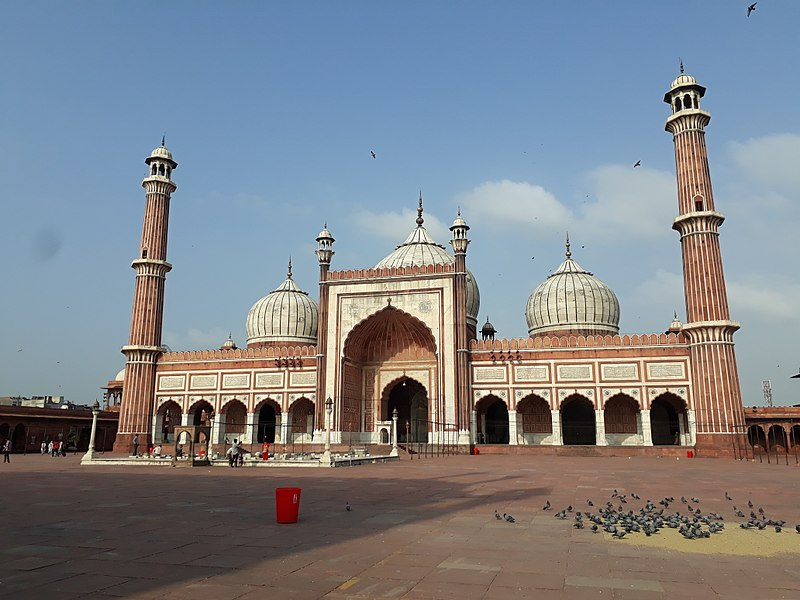

TypeError: color must be int or single-element tuple

In [28]:
for id,d in retrieved_data.items():
    if not id in remaining_ids:
        continue
    # try:
    ans = get_test_answer(d, model, image_processor, tokenizer, max_length, device)
    if ans == "":
        continue
    # except Exception as e:
    #     print(e)
    #     continue

In [ ]:
count = 0
for id,d in val_data.items():
    count += 1
    ans = get_answer(d, model, image_processor, tokenizer, max_length, device)
    print(f"Ques: {d['Q']}\nAssistant: {ans}\nGT: {d['A'][0]}\n")
    if count == 10:
        break

In [ ]:
prompt_question

In [1]:
# Map test set images to IDs
import json
test_dir = '/mnt/disks/data/webqa/WebQA_test.json'
retrieved_dir = '/mnt/disks/data/webqa/WebQA_retrieved_test.json'

with open(test_dir, 'r') as f:
    test_data = json.load(f)

with open(retrieved_dir, 'r') as f:
    retrieved_data = json.load(f)

img_url_to_id = {}

for qid,d in test_data.items():
    for img in d['img_Facts']:
        img_url_to_id[img['imgUrl']] = img['image_id']

In [ ]:
list(img_url_to_id.items())

In [ ]:
from collections import defaultdict

t = defaultdict(int)
i = defaultdict(int)
for id,d in retrieved_data.items():
    t[len(d['txt_Facts'])] += 1
    i[len(d['img_Facts'])] += 1

print(t)
print(i)

In [ ]:
# Image context (1,2) + Text context (1,2) + Question
# For cases where Img context = 0; use multimodal = False config and re-run the generation
def get_multihop_image_prompt(titles):
    question = f"{DEFAULT_IMAGE_TOKEN} This is the first image.\nTitle: {titles[0]}\n\nNow, let's look at another image: {DEFAULT_IMAGE_TOKEN} Title: {titles[1]}\n"
    return question

def get_si_prompt(titles):
    question = f"{DEFAULT_IMAGE_TOKEN} Consider this image\nTitle: {titles[0]}\n"
    return question

def get_multihop_text_propmpt(texts):
    question = f"Fact 1: {texts[0]}\n\nFact 2: {texts[1]}\n"
    return question

def get_single_text_propmpt(texts):
    question = f"Fact: {texts[0]}\n"
    return question

In [6]:
# Evaluate score on the val set
import json

answers = "/mnt/disks/data/webqa/ans_val_imgs_base.txt"
with open("/mnt/disks/data/webqa/WebQA_train_val.json", 'r') as f:
    train_val_dataset = json.load(f)

ans_data = {}
with open(answers, 'r') as f:
    for row in f:
        qid, res = row.split("\t")
        ans_data[qid] = res.strip()
eval_data = {k:v for k, v in train_val_dataset.items() if v['split'] == 'val' and v['Qcate'].lower() in ['color', 'shape', 'yesno', 'number']}
len(eval_data)

1340

In [9]:
from eval_1022 import *
import sys
qa_results = {}
for k in eval_data.keys():
    question = eval_data[k]['Q']
    if k not in ans_data:
        continue
    answer = [ans_data[k]]
    label = eval_data[k]['A']

    Qcate = eval_data[k]['Qcate'].lower()
    if Qcate == 'color': 
        F1_avg, F1_max, EM, RE_avg, PR_avg = compute_vqa_metrics(answer, label[0], "", color_set)
        sys.stdout.flush()
    elif Qcate == 'shape': 
        F1_avg, F1_max, EM, RE_avg, PR_avg = compute_vqa_metrics(answer, label[0], "", shape_set)
    elif Qcate == 'yesno': 
        F1_avg, F1_max, EM, RE_avg, PR_avg = compute_vqa_metrics(answer, label[0], "", yesno_set)
    elif Qcate == 'number': 
        F1_avg, F1_max, EM, RE_avg, PR_avg = compute_vqa_metrics(answer, label[0], "", {"NUMBER"})
    else:
        continue
    if not Qcate in qa_results:
        qa_results[Qcate] = []
    qa_results[Qcate].append(PR_avg)

In [10]:
import numpy as np
for k,v in qa_results.items():
    print(f"{k}: {np.mean(v)}")

yesno: 0.6034271725826194
shape: 0.3926940639269406
color: 0.7430167597765364
number: 0.556758530183727


In [4]:
# What answers are remaining?
ans_dir = 'ans_test_imgs_base.txt'
with open(ans_dir, 'r') as f:
    ans_ids = set()
    for line in f:
        ans_ids.add(line.split('\t')[0])

remaining_ids = []
for id,d in test_data.items():
    if id not in ans_ids:
        remaining_ids.append(id)
len(remaining_ids)

558